In [391]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2
from skimage.feature import peak_local_max
from skimage.color import rgb2gray
from multiprocess import Pool
import pickle

0.043137254901960784


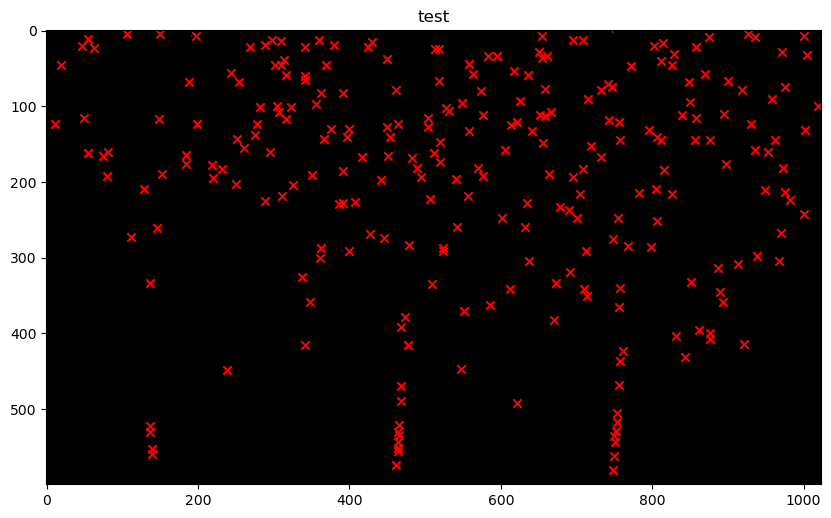

In [375]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2024-02-07/'

imagesDir = []
for imageDir in glob.glob(directory+'*.tif'):
    imagesDir.append(imageDir)
imagesDir = np.sort(imagesDir)

# TEST
testImg = rgb2gray(cv2.imread(imagesDir[0])[200:800,:])
print(np.max(testImg))
testImg /= np.max(testImg)
testImg = np.where(testImg>0.20,testImg,0)
plt.figure(figsize=(10,16))
plt.imshow(testImg,cmap='Greys_r')
# detect peaks
peaks = peak_local_max(testImg,min_distance=4)
for peak in peaks:
    plt.scatter(peak[1],peak[0],color='red',marker='x')
plt.title('test')
plt.show()

In [369]:
imagesDir[-1]

'/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2024-02-07/B00200.tif'

# Read all particles

In [495]:
pos_t = []
for imageDir in imagesDir[::]:
    image = rgb2gray(cv2.imread(imageDir)[200:800,:])
    image /= 0.03529411764705882
    image = np.where(image>0.20,image,0)
    peaks = peak_local_max(image,min_distance=4)
    pos_t.append(peaks)
    # print(imageDir)

## Print a few to check

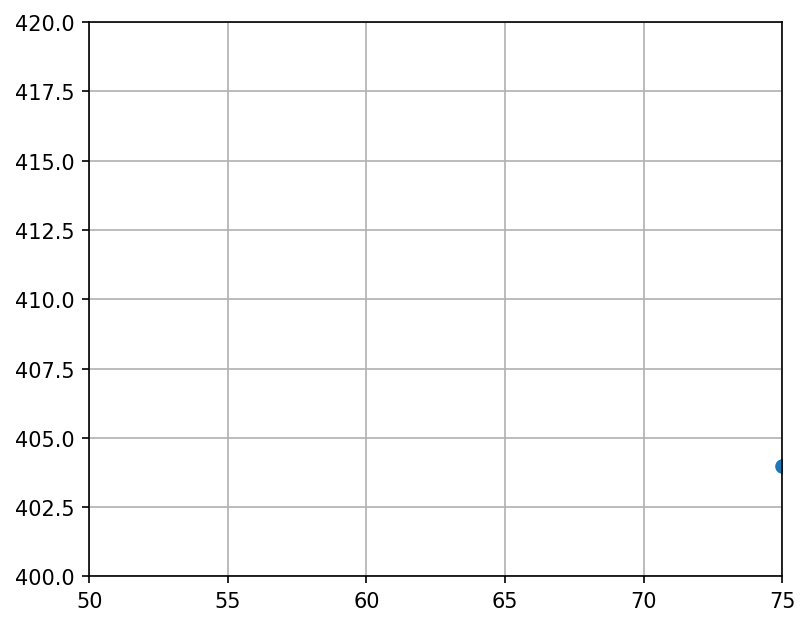

In [444]:
plt.figure(dpi=150)
myColors = np.tile(['tab:blue','tab:orange','purple','green','red'],10)
for ip,peaks in enumerate(pos_t[:30]):
    plt.scatter(peaks[:,1],peaks[:,0],color=myColors[ip])
plt.gca().invert_yaxis()
plt.grid()
plt.ylim(400,420)
plt.xlim(50,75)
plt.gca().set_aspect('equal')
plt.show()

# Find trajectories

In [445]:
class trajectory:
    def __init__(self, position):
        self.position = position
    def append(self,position):
        self.position = np.vstack((self.position,position))
    def lastPos(self):
        if self.position.shape==(2,):
            return self.position
        else:
            return self.position[-1]
        
def dist(a,b):
    return np.linalg.norm(a-b)
def vector(a,b):
    return [b[0]-a[0],b[1]-a[1]]

# create trajectory list
trajectories = []
# fill up list with first-frame particles (they're all new trajectories)
for _,particle in enumerate(pos_t[0]):
    trajectories.append(trajectory(particle))

for time,particlesInFrame in enumerate(pos_t[1:]): # loop over frames
    for _,particle in enumerate(particlesInFrame): # loop over particles 
        matched = 0 # is that particle matched?
        for tr in trajectories: # loop over known trajectories
            
            # this snippet of code does the job for a non-predictor case
            # if dist(particle,tr.lastPos())<6:
            #     tr.append(particle)
            #     matched = 1

            if tr.position.shape==(2,): # if the trajectory is one point (no prediction possible)
                if dist(particle,tr.lastPos())<6: # within a sphere of radius r
                    tr.append(particle)
                    matched = 1 # found a particle
            else: # if the trajectory is more than one point, i can predict
                predicted = tr.position[-1] + vector(tr.position[-2],tr.position[-1])
                if dist(particle,predicted) < 5: # within a sphere of radius r
                    tr.append(particle)
                    matched = 1  # found a particle
            if matched == 0 and time>5 and tr.position.shape!=(2,): # if the particle is not matched to a traj AND time is far enough AND it's not a new trajectory
                if tr.position.shape[0]<3 : del tr # if the trajectory is too short, delete it, it's a dead end. 
        if matched==0: # if still not matched, it means it's a new track
            trajectories.append(trajectory(particle))
        
    print(f'time {time}')

with open(directory+f'trajectories_{len(trajectories)}', "wb") as fp:   #Pickling
    pickle.dump(trajectories, fp)

time 0


KeyboardInterrupt: 

In [496]:
# create trajectory list
trajectories = []
# fill up list with first-frame particles (they're all new trajectories)
for _,particle in enumerate(pos_t[0]):
    trajectories.append(trajectory(particle))

radius = 7

def lookForParticle(knownParticles,knownPosition,radius):
    xIndeces = np.where(np.logical_and(knownParticles[:,1]<knownPosition[1]+radius,knownParticles[:,1]>knownPosition[1]-radius)) # these are indeces
    yIndeces = np.where(np.logical_and(knownParticles[:,0]<knownPosition[0]+radius,knownParticles[:,0]>knownPosition[0]-radius)) # these are indeces
    intersection = np.intersect1d(xIndeces,yIndeces)
    return intersection

for time,particlesInFrame in enumerate(pos_t[1:]): # loop over frames
    for tr in trajectories:
        if tr.position.shape==(2,): # if the trajectory is one point (no prediction possible)
            intersection = lookForParticle(particlesInFrame,tr.lastPos(),radius)
            if len(intersection)==0: 
                continue # AND WHAT?
            elif len(intersection)>1:
                continue # it means that I have multiple particles...
            else:
                tr.append(particlesInFrame[intersection])
        else: # if the trajectory is longer, I can do better
            predicted = tr.position[-1] + vector(tr.position[-2],tr.position[-1])
            intersection = lookForParticle(particlesInFrame,predicted,radius)
            if len(intersection)==0: 
                continue # AND WHAT?
            elif len(intersection)>1:
                continue # it means that I have multiple particles...
            else:
                tr.append(particlesInFrame[intersection])

        
    print(f'time {time}')

time 0
time 1
time 2
time 3
time 4
time 5
time 6
time 7
time 8
time 9
time 10
time 11
time 12
time 13
time 14
time 15
time 16
time 17
time 18
time 19
time 20
time 21
time 22
time 23
time 24
time 25
time 26
time 27
time 28
time 29
time 30
time 31
time 32
time 33
time 34
time 35
time 36
time 37
time 38
time 39
time 40
time 41
time 42
time 43
time 44
time 45
time 46
time 47
time 48
time 49
time 50
time 51
time 52
time 53
time 54
time 55
time 56
time 57
time 58
time 59
time 60
time 61
time 62
time 63
time 64
time 65
time 66
time 67
time 68
time 69
time 70
time 71
time 72
time 73
time 74
time 75
time 76
time 77
time 78
time 79
time 80
time 81
time 82
time 83
time 84
time 85
time 86
time 87
time 88
time 89
time 90
time 91
time 92
time 93
time 94
time 95
time 96
time 97
time 98
time 99
time 100
time 101
time 102
time 103
time 104
time 105
time 106
time 107
time 108
time 109
time 110
time 111
time 112
time 113
time 114
time 115
time 116
time 117
time 118
time 119
time 120
time 121
time 122
tim

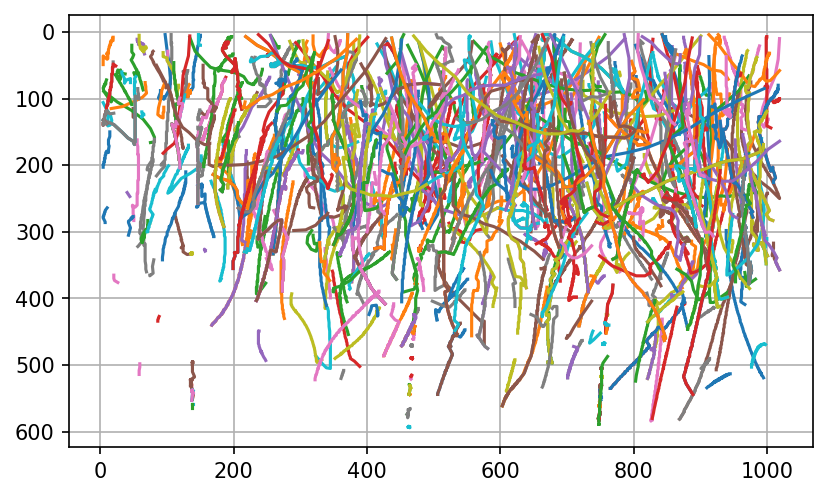

In [497]:
plt.figure(dpi=150)
for tr in trajectories:
    if tr.position.shape==(2,): continue
    # if tr.position.shape[0]<50:continue
    # print(tr.position.shape)
    plt.plot(tr.position[:,1],tr.position[:,0])
plt.grid()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
# plt.ylim(400,420)
# plt.xlim(50,75)
plt.show()

# Get velocities

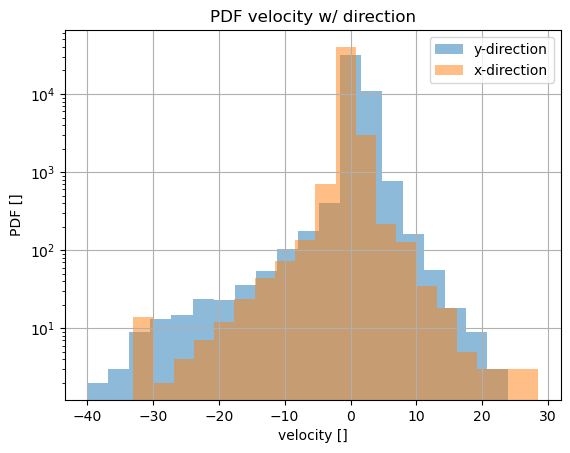

In [498]:
dt = 1 # s
velocities = np.array([np.nan,np.nan])

for i,tr in enumerate(trajectories[1:]):
    if tr.position.shape[0]<50:continue
    velocities = np.vstack((velocities,np.gradient(tr.position,axis=0)/dt))

nbins = 20
plt.hist(velocities[:,0].flatten(),label='y-direction',alpha=0.5,bins=nbins)
plt.hist(velocities[:,1].flatten(),label='x-direction',alpha=0.5,bins=nbins)
# plt.plot(200+np.linspace(-800,800,200),
#          np.exp(-(np.linspace(-800,800,200)/5e2)**2)*15,
#          label='gaussian1 line')

plt.title('PDF velocity w/ direction')
plt.xlabel('velocity []')
plt.ylabel('PDF []')
plt.yscale('log')
# plt.xlim(-50,50)
# plt.ylim(1e0,1e5)
plt.grid()
plt.legend()
plt.show()

In [440]:
for tr in trajectories:
    print(tr.position.shape[0])

21
200
111
56
96
200
193
165
202
197
139
90
79
140
70
113
82
200
153
200
84
108
77
127
102
80
200
117
92
110
100
123
99
157
188
76
143
152
47
178
174
194
103
203
66
78
216
102
157
190
75
100
81
72
110
62
74
109
89
52
200
88
45
56
171
139
67
114
119
155
200
183
134
117
63
110
69
199
161
116
102
42
47
91
200
220
131
182
115
47
75
157
31
200
116
128
66
71
76
81
66
112
121
124
84
124
101
131
142
118
117
70
88
14
102
113
120
34
175
142
139
180
64
31
129
46
108
149
59
98
134
87
5
188
79
77
68
120
129
77
86
94
187
115
60
76
75
90
192
188
77
119
72
89
59
58
96
104
74
142
45
80
93
189
146
47
66
67
97
100
47
124
41
97
47
73
84
154
94
53
94
39
146
178
322
242
111
208
242
64
85
147
113
177
82
200
137
79
205
200
188
200
80
92
119
121
100
192
98
96
322
10
217
138
193
191
173
164
122
164
185
201
173
52
36
154
150
64
64
170
136
160
215
157
181
200
187
169
174
67
74
201
68
68
50
150
19
149
90
200
38
119
26
66
96
105
32
115
139
91
58
73
215
47
39
182
108
226
182
112
87
92
221
46
191
225
74
44
46
95
83
2